https://github.com/Chancylin/shap_loss/blob/master/Census%20income%20classification%20with%20XGBoost_shap_loss.ipynb

In [5]:
!pip install shap --upgrade

Requirement already up-to-date: shap in /anaconda3/lib/python3.6/site-packages (0.37.0)


In [7]:
from sklearn.model_selection import train_test_split
import xgboost
import shap
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import scipy

# print the JS visualization code to the notebook
shap.initjs()

%load_ext autoreload
%autoreload 2

# add the helper functions for this example
import sys
sys.path.insert(0, "./helper_functions/")

from shap_help import subsample_data, plot_shap_loss, plot_shap_loss_compare

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Regular SHAP values: feature contribution to prediction

In [8]:
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = xgboost.DMatrix(X_train, label=y_train)
d_test = xgboost.DMatrix(X_test, label=y_test)

In [9]:
print(X.columns.tolist())
print(X.shape)

['Age', 'Workclass', 'Education-Num', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Capital Gain', 'Capital Loss', 'Hours per week', 'Country']
(32561, 12)


In [10]:
print(X.shape)

print("imbalance ratio: entire dataset")
print(y.sum()/len(y))

print("imbalance ratio: training dataset")
print(y_train.sum()/len(y_train))

print("imbalance ratio: test dataset")
print(y_test.sum()/len(y_test))

X.describe()

(32561, 12)
imbalance ratio: entire dataset
0.2408095574460244
imbalance ratio: training dataset
0.24105497542997542
imbalance ratio: test dataset
0.23982803623522186


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581646,3.868892,10.080679,2.611836,6.572740,2.494518,3.665858,0.669205,1077.649170,87.303833,40.437454,36.718866
std,13.640442,1.455960,2.572562,1.506222,4.228857,1.758232,0.848806,0.470506,7385.911621,403.014771,12.347933,7.823782
min,17.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,4.000000,9.000000,2.000000,3.000000,0.000000,4.000000,0.000000,0.000000,0.000000,40.000000,39.000000
50%,37.000000,4.000000,10.000000,2.000000,7.000000,3.000000,4.000000,1.000000,0.000000,0.000000,40.000000,39.000000
75%,48.000000,4.000000,12.000000,4.000000,10.000000,4.000000,4.000000,1.000000,0.000000,0.000000,45.000000,39.000000
max,90.000000,8.000000,16.000000,6.000000,14.000000,5.000000,4.000000,1.000000,99999.000000,4356.000000,99.000000,41.000000


In [11]:
params = {
    "eta": 0.01,
    "objective": "binary:logistic",
    "subsample": 0.5,
    "base_score": np.mean(y_train),
    "eval_metric": "logloss"
}
model = xgboost.train(params, d_train, 5000, evals = [(d_test, "test")], verbose_eval=100, early_stopping_rounds=20)

[0]	test-logloss:0.54663
Will train until test-logloss hasn't improved in 20 rounds.
[100]	test-logloss:0.36373
[200]	test-logloss:0.31793
[300]	test-logloss:0.30061
[400]	test-logloss:0.29207
[500]	test-logloss:0.28678
[600]	test-logloss:0.28381
[700]	test-logloss:0.28181
[800]	test-logloss:0.28064
[900]	test-logloss:0.27992
[1000]	test-logloss:0.27928
Stopping. Best iteration:
[999]	test-logloss:0.27927



## Classic feature attributions

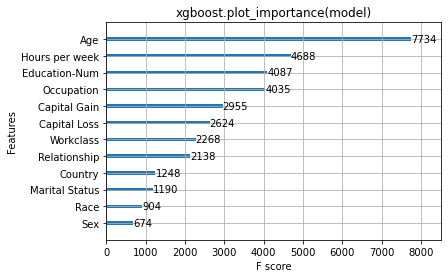

In [12]:
xgboost.plot_importance(model)
pl.title("xgboost.plot_importance(model)")
pl.show()

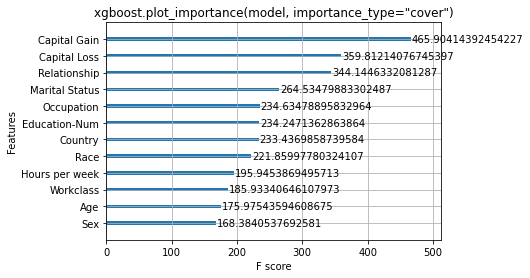

In [13]:
xgboost.plot_importance(model, importance_type="cover")
pl.title('xgboost.plot_importance(model, importance_type="cover")')
pl.show()

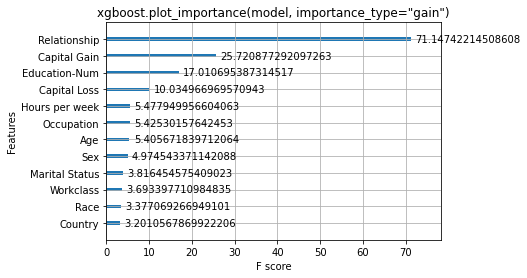

In [14]:
xgboost.plot_importance(model, importance_type="gain")
pl.title('xgboost.plot_importance(model, importance_type="gain")')
pl.show()

## Explain predictions

In [15]:
# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_display.iloc[0,:])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_display.iloc[:1000,:])

In [ ]:
shap.summary_plot(shap_values, X_display, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, X)

# Explain the Log-Loss of the Model with TreeExplainer